In [1]:
import os,sys
import numpy as np
from scipy.ndimage import gaussian_filter
import math
import itertools
import matplotlib.pyplot as plt
%matplotlib  widget 

In [2]:
n    = 100      # number of pixels
nd   = 60       # number of dates, ~2 years if dt=12 days, has to be even 
m = 100         # number of iterations (~number of filter windows on 2D plot)

In [3]:
pop1_rate       = 0     # this is like 0 rad/igram 
                            # breaks down when a rate is >pi/2 different than other rate
pop2_rate       = -1      # this is like 1 rad/igram 

# initialize array for cumTPCs for each pop1_percent
cumTPC = np.ndarray((101),dtype='float')

# loop through each percent 0-100
for pop1_percent in range(101):

    # initialize matrix for SLC phase values 
    SLCphs = np.ndarray((nd,n),dtype='float')
    
    # for each SLC, but in pop1_percent amount of pop1_rate, rest is pop2_rate
    for date in range(nd):
        # no noise 
        SLCphs[date,:]              = pop2_rate
        SLCphs[date,0:pop1_percent] = pop1_rate
        # noise added 
        #SLCphs[date,:]              = np.random.normal(pop2_rate,phs_std,(n))
        #SLCphs[date,0:pop1_percent] = np.random.normal(pop1_rate,phs_std,(pop1_percent))

    # create SLCs as complex nums
    slcs    = np.exp(1j*SLCphs)
    slcs    = np.cumprod(slcs,0) # this makes sure that the rate is carried through 

    # create ints by complex conj of sequential SLCs 
    ints        = slcs[0:-1]*np.conj(slcs[1::]) # (nd-1,n) shape: nd-1 ints, n pixels 
    intsSkip1   = slcs[0:-2]*np.conj(slcs[2::])

    # initialize matrix to hold triplets 
    trips = np.ndarray((nd-2),dtype='float') 

    # loop through triplets
    for i in range(nd-2): 
        ab = ints[i]
        bc = ints[i+1]
        ac = intsSkip1[i]
        # "filter" them (just take average of the 100 pixels by summing then taking angle)
        abFilt = np.angle(np.sum(ab))
        bcFilt = np.angle(np.sum(bc))
        acFilt = np.angle(np.sum(ac))
        # calculate triplet
        trips[i] = abFilt + bcFilt - acFilt
    # sum the triplets over the whole interval, put into array
    cumTPC[pop1_percent] = np.sum(trips)

Plot it.

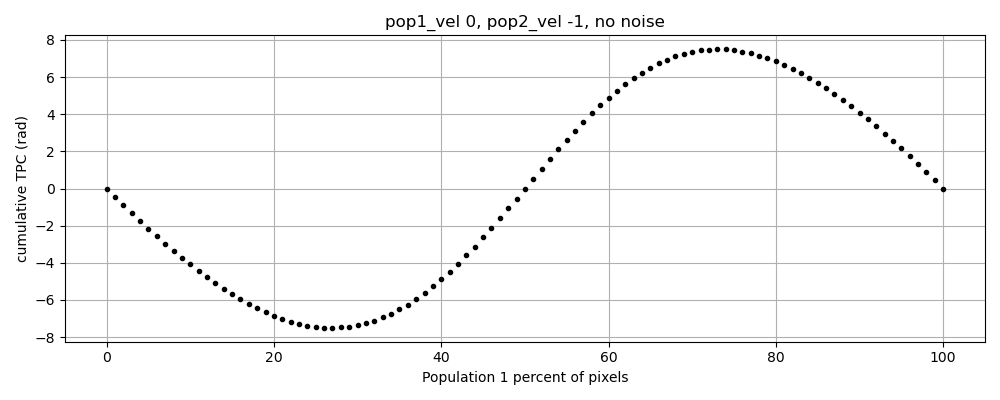

In [4]:
percents = range(101)

plt.figure(figsize=(10,4),tight_layout=True)
plt.plot(percents,cumTPC,'k.')
plt.xlabel('Population 1 percent of pixels')
plt.ylabel('cumulative TPC (rad)')
plt.title('pop1_vel '+str(pop1_rate)+', pop2_vel '+str(pop2_rate)+', no noise')
#plt.xlim([0,100])
plt.grid()
plt.show()

Now, loop over pop1_rate and pop2_rate combos (for each, between -0.5 and 0.5 with 0.05 increments) and calculate the maximum cumTPC and what pop1_percent that corresponds to, then plot them as correlation matrices.

In [5]:
# this array holds the max cumTPC value for each combo of pop1/2 rates
numVels = 31
maxTPC = np.ndarray((numVels,numVels),dtype='float')
maxPop1Percents = np.ndarray((numVels,numVels),dtype='float')
# this is for picking out which pop1_percent corresponds to the maximum cumTPC value for each rate combo
pop1_percents = range(101)

#pop1_rates = np.arange(-0.5,0.5001,0.05)
pop1_rates = np.linspace(-0.75,0.75,num=numVels,endpoint=True)
#pop2_rates = np.arange(-0.5,0.5001,0.05)
pop2_rates = np.linspace(-0.75,0.75,num=numVels,endpoint=True)

for p1 in range(len(pop1_rates)):
    for p2 in range(len(pop2_rates)):

        # initialize array for cumTPCs for each pop1_percent
        cumTPC = np.ndarray((101),dtype='float')

        # loop through each percent 0-100
        for pop1_percent in range(101):

            # initialize matrix for SLC phase values 
            SLCphs = np.ndarray((nd,n),dtype='float')
            
            # for each SLC, but in pop1_percent amount of pop1_rate, rest is pop2_rate
            for date in range(nd):
                # no noise 
                SLCphs[date,:]              = pop2_rates[p1]
                SLCphs[date,0:pop1_percent] = pop1_rates[p2]
                # noise added 
                #SLCphs[date,:]              = np.random.normal(pop2_rate,phs_std,(n))
                #SLCphs[date,0:pop1_percent] = np.random.normal(pop1_rate,phs_std,(pop1_percent))

            # create SLCs as complex nums
            slcs    = np.exp(1j*SLCphs)
            slcs    = np.cumprod(slcs,0) # this makes sure that the rate is carried through 

            # create ints by complex conj of sequential SLCs 
            ints        = slcs[0:-1]*np.conj(slcs[1::]) # (nd-1,n) shape: nd-1 ints, n pixels 
            intsSkip1   = slcs[0:-2]*np.conj(slcs[2::])

            # initialize matrix to hold triplets 
            trips = np.ndarray((nd-2),dtype='float') 

            # loop through triplets
            for i in range(nd-2): 
                ab = ints[i]
                bc = ints[i+1]
                ac = intsSkip1[i]
                # "filter" them (just take average of the 100 pixels by summing then taking angle)
                abFilt = np.angle(np.sum(ab))
                bcFilt = np.angle(np.sum(bc))
                acFilt = np.angle(np.sum(ac))
                # calculate triplet
                trips[i] = abFilt + bcFilt - acFilt
            
            # sum the triplets over the whole interval, put into array
            cumTPC[pop1_percent] = np.sum(trips)

        # find the maximum cumTPC value and it's corresponding pop1_percent 
        maxTPC[p1,p2] = max(cumTPC)
        maxPop1Percents[p1,p2] = pop1_percents[np.argmax(cumTPC)]

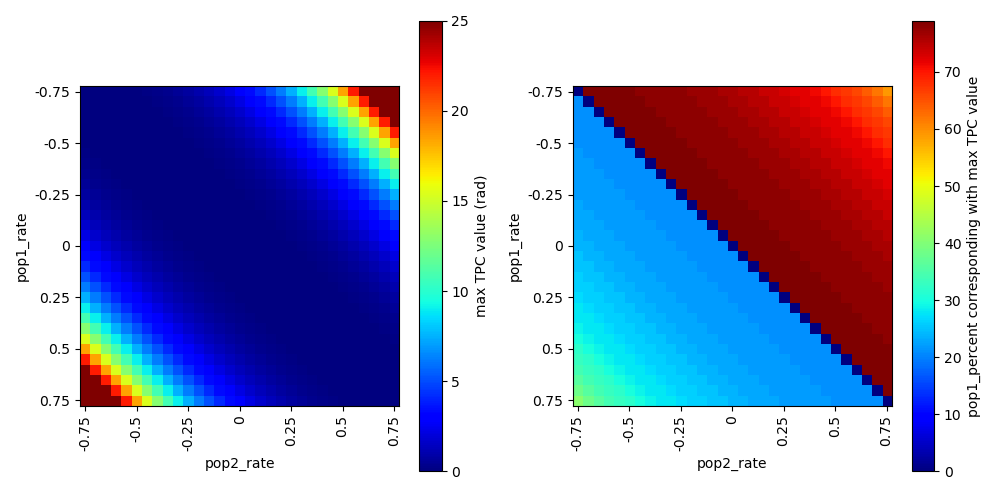

In [6]:
plt.figure(figsize=(10,5),tight_layout=True)
plt.subplot(1,2,1)
plt.imshow(maxTPC,cmap='jet',vmin=0,vmax=25)
plt.ylabel('pop1_rate')
plt.xlabel('pop2_rate')
# plt.xticks(ticks=range(len(pop2_rates)),labels=pop2_rates,rotation='vertical')
# plt.yticks(ticks=range(len(pop1_rates)),labels=pop1_rates)
plt.xticks(ticks=[0,5,10,15,20,25,30],labels=[-0.75,-0.5,-0.25,0,0.25,0.5,0.75],rotation='vertical')
plt.yticks(ticks=[0,5,10,15,20,25,30],labels=[-0.75,-0.5,-0.25,0,0.25,0.5,0.75])
plt.colorbar(label='max TPC value (rad)')
plt.subplot(1,2,2)
plt.imshow(maxPop1Percents,cmap='jet')
plt.ylabel('pop1_rate')
plt.xlabel('pop2_rate')
plt.xticks(ticks=[0,5,10,15,20,25,30],labels=[-0.75,-0.5,-0.25,0,0.25,0.5,0.75],rotation='vertical')
plt.yticks(ticks=[0,5,10,15,20,25,30],labels=[-0.75,-0.5,-0.25,0,0.25,0.5,0.75])
plt.colorbar(label='pop1_percent corresponding with max TPC value')
plt.show()

Define a function for calculating the cumTPC curve for a given pop1_rate and a given pop2_rate.

In [7]:
def calc_cumTPC_for_given_pop_rates(pop1_rate_input,pop2_rate_input):

    nd = 60
    n = 100
    
    # initialize array for cumTPCs for each pop1_percent
    cumTPC = np.zeros((101),dtype='float')

    # loop through each percent 0-100
    for pop1_percent in range(101):

        # initialize matrix for SLC phase values 
        SLCphs = np.zeros((nd,n),dtype='float')
        
        # for each SLC, but in pop1_percent amount of pop1_rate, rest is pop2_rate
        for date in range(nd):
            # no noise 
            SLCphs[date,:]              = pop2_rate_input
            SLCphs[date,0:pop1_percent] = pop1_rate_input
            # noise added 
            #SLCphs[date,:]              = np.random.normal(pop2_rate,phs_std,(n))
            #SLCphs[date,0:pop1_percent] = np.random.normal(pop1_rate,phs_std,(pop1_percent))

        # create SLCs as complex nums
        slcs    = np.exp(1j*SLCphs)
        slcs    = np.cumprod(slcs,0) # this makes sure that the rate is carried through 

        # create ints by complex conj of sequential SLCs 
        ints        = slcs[0:-1]*np.conj(slcs[1::]) # (nd-1,n) shape: nd-1 ints, n pixels 
        intsSkip1   = slcs[0:-2]*np.conj(slcs[2::])

        # initialize matrix to hold triplets 
        trips = np.ndarray((nd-2),dtype='float') 

        # loop through triplets
        for i in range(nd-2): 
            ab = ints[i]
            bc = ints[i+1]
            ac = intsSkip1[i]
            # "filter" them (just take average of the 100 pixels by summing then taking angle)
            abFilt = np.angle(np.sum(ab))
            bcFilt = np.angle(np.sum(bc))
            acFilt = np.angle(np.sum(ac))
            # calculate triplet
            trips[i] = abFilt + bcFilt - acFilt
        # sum the triplets over the whole interval, put into array
        cumTPC[pop1_percent] = np.sum(trips)

    return cumTPC

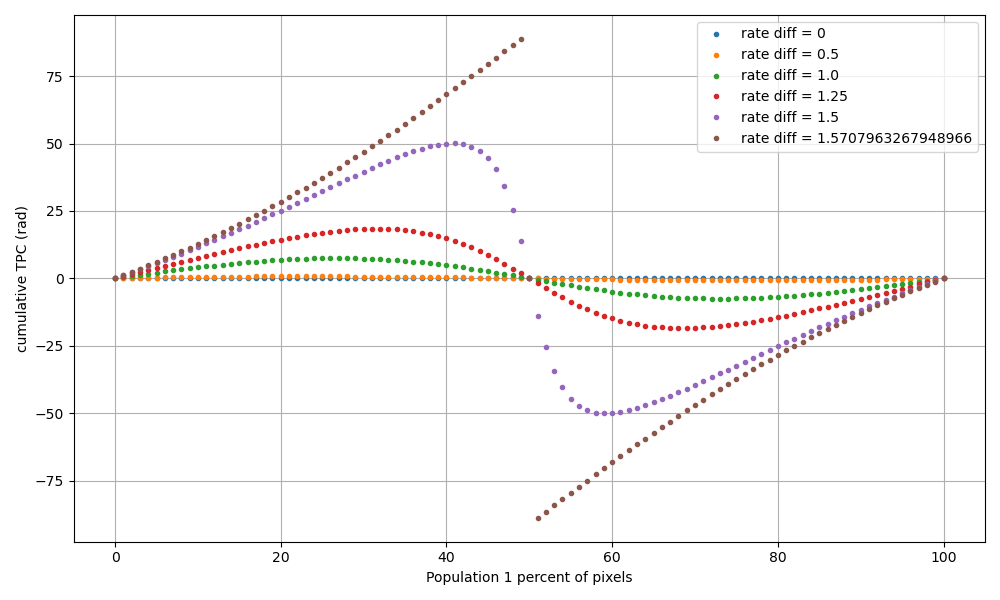

In [8]:
percents = range(101)
# p1_rates = [-np.pi/2, -1.25, -1.5, -1, -0.5, -0.25, 0, -0.25, -0.5, -0.75]
# p2_rates = [0       , 0    , 0   , 0 , 0   , 0    , 0, 0.25,  0.5,  0.75]

rate_diffs = np.arange(0,np.pi/2,0.15)
rate_diffs = [0,0.5,1.0,1.25,1.5,np.pi/2]

plt.figure(figsize=(10,6),tight_layout=True)

for i in np.arange(0,len(rate_diffs)):
    tempTPC = calc_cumTPC_for_given_pop_rates(0,rate_diffs[i])
    #label = 'p1 '+str(p1_rates[i])+', p2 '+str(p2_rates[i])
    label = 'rate diff = '+str(rate_diffs[i])
    plt.plot(percents,tempTPC,'.',label=label)
    del tempTPC

plt.xlabel('Population 1 percent of pixels')
plt.ylabel('cumulative TPC (rad)')
#plt.title('pop1_vel '+str(pop1_rate)+', pop2_vel '+str(pop2_rate)+', no noise')
#plt.xlim([0,100])
plt.grid()
plt.legend()
plt.show()

Now at a single pop1_percent (try 25%, maybe 30%), calculate cumTPC for a range of rate diffs.

In [9]:
def calc_cumTPC_for_given_pop1_percent(pop1_percent):

    nd = 60
    n = 100

    pop_rate_diffs = np.arange(0,1.51,0.05)
    numRateDiffs = len(pop_rate_diffs)
    pop2_rate = 0.0

    # initialize array for cumTPCs for each rate diff
    cumTPC = np.ndarray((numRateDiffs),dtype='float')

    # loop through each rate diff
    for j in range(numRateDiffs):

        # set the pop1 and pop2 rates
        pop1_rate = pop_rate_diffs[j]

        # initialize matrix for SLC phase values 
        SLCphs = np.ndarray((nd,n),dtype='float')
        
        # for each SLC, but in pop1_percent amount of pop1_rate, rest is pop2_rate
        for date in range(nd):
            # no noise 
            SLCphs[date,:]              = pop2_rate
            SLCphs[date,0:pop1_percent] = pop1_rate
            # noise added 
            #SLCphs[date,:]              = np.random.normal(pop2_rate,phs_std,(n))
            #SLCphs[date,0:pop1_percent] = np.random.normal(pop1_rate,phs_std,(pop1_percent))

        # create SLCs as complex nums
        slcs    = np.exp(1j*SLCphs)
        slcs    = np.cumprod(slcs,0) # this makes sure that the rate is carried through 

        # create ints by complex conj of sequential SLCs 
        ints        = slcs[0:-1]*np.conj(slcs[1::]) # (nd-1,n) shape: nd-1 ints, n pixels 
        intsSkip1   = slcs[0:-2]*np.conj(slcs[2::])

        # initialize matrix to hold triplets 
        trips = np.ndarray((nd-2),dtype='float') 

        # loop through triplets
        for i in range(nd-2): 
            ab = ints[i]
            bc = ints[i+1]
            ac = intsSkip1[i]
            # "filter" them (just take average of the 100 pixels by summing then taking angle)
            abFilt = np.angle(np.sum(ab))
            bcFilt = np.angle(np.sum(bc))
            acFilt = np.angle(np.sum(ac))
            # calculate triplet
            trips[i] = abFilt + bcFilt - acFilt
        # sum the triplets over the whole interval, put into array
        cumTPC[j] = np.sum(trips)
    return cumTPC

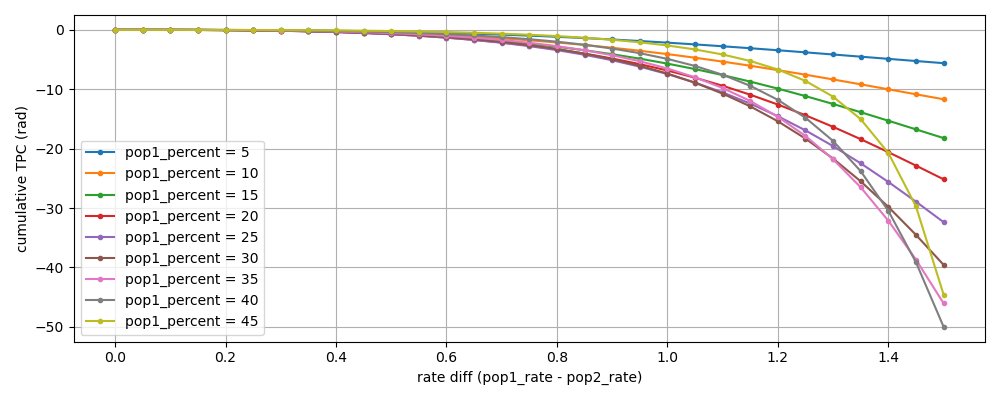

In [10]:
pop_rate_diffs = np.arange(0,1.51,0.05)
pop1_percents = np.arange(5,46,5)

plt.figure(figsize=(10,4),tight_layout=True)

for i in range(len(pop1_percents)):
    cumTPC = calc_cumTPC_for_given_pop1_percent(pop1_percents[i])
    label = 'pop1_percent = '+str(pop1_percents[i])
    plt.plot(pop_rate_diffs,cumTPC,'.-',label=label)
    del cumTPC

plt.xlabel('rate diff (pop1_rate - pop2_rate)')
plt.ylabel('cumulative TPC (rad)')
plt.legend()
plt.grid()
plt.show()

Now loop through a grid of rate diffs and pop1_percents to calculate cumTPC for each combo. 

In [11]:
def calc_cumTPC_for_given_rate_diff_and_pop1_percent(rate_diff,pop1_perc):

    nd = 60
    n = 100

    # set the pop1 and pop2 rates
    pop2_rate = 0.0
    pop1_rate = rate_diff

    # initialize matrix for SLC phase values 
    SLCphs = np.ndarray((nd,n),dtype='float')
    
    # for each SLC, but in pop1_percent amount of pop1_rate, rest is pop2_rate
    for date in range(nd):
        # no noise 
        SLCphs[date,:]              = pop2_rate
        SLCphs[date,0:int(pop1_perc)]    = pop1_rate

    # create SLCs as complex nums
    slcs    = np.exp(1j*SLCphs)
    slcs    = np.cumprod(slcs,0) # this makes sure that the rate is carried through 

    # create ints by complex conj of sequential SLCs 
    ints        = slcs[0:-1]*np.conj(slcs[1::]) # (nd-1,n) shape: nd-1 ints, n pixels 
    intsSkip1   = slcs[0:-2]*np.conj(slcs[2::])

    # initialize matrix to hold triplets 
    trips = np.ndarray((nd-2),dtype='float') 

    # loop through triplets
    for i in range(nd-2): 
        ab = ints[i]
        bc = ints[i+1]
        ac = intsSkip1[i]
        # "filter" them (just take average of the 100 pixels by summing then taking angle)
        abFilt = np.angle(np.sum(ab))
        bcFilt = np.angle(np.sum(bc))
        acFilt = np.angle(np.sum(ac))
        # calculate triplet
        trips[i] = abFilt + bcFilt - acFilt
    
    # sum the triplets over the whole interval, put into array
    TPC = np.sum(trips)
    
    return TPC

Loop over a range of rate diffs and pop1_percents and get an array that I will color/contour based on TPC 

In [12]:
num_to_loop = 100

rate_diffs_to_loop = np.linspace(0,1.5,num=num_to_loop,endpoint=True)
pop1_percents_to_loop = np.linspace(0,100,num=num_to_loop,endpoint=True)

TPC = np.ndarray((num_to_loop,num_to_loop),dtype='float')

for i in range(num_to_loop):        # rate diffs
    for j in range(num_to_loop):    # pop1 percents

        # call the function 
        TPC[i,j] = calc_cumTPC_for_given_rate_diff_and_pop1_percent(rate_diffs_to_loop[i],pop1_percents_to_loop[j])

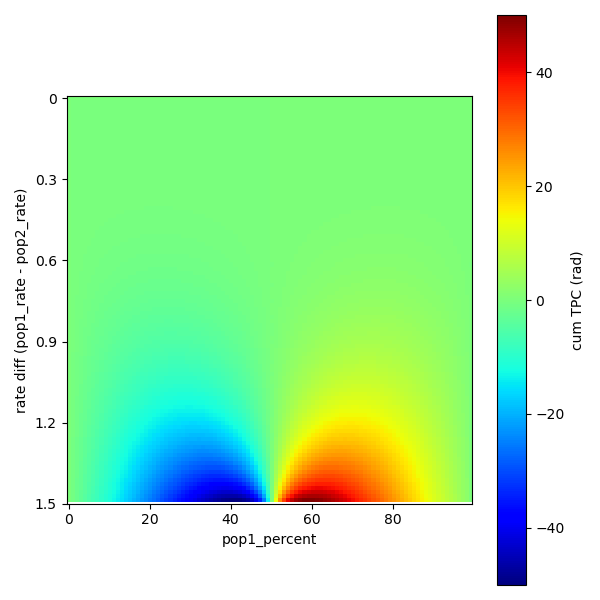

In [13]:
plt.figure(figsize=(6,6),tight_layout=True)
plt.imshow(TPC,cmap='jet')
plt.ylabel('rate diff (pop1_rate - pop2_rate)')
plt.xlabel('pop1_percent')
plt.yticks(ticks=[0,20,40,60,80,100],labels=[0,0.3,0.6,0.9,1.2,1.5])
plt.colorbar(label='cum TPC (rad)')
plt.show()

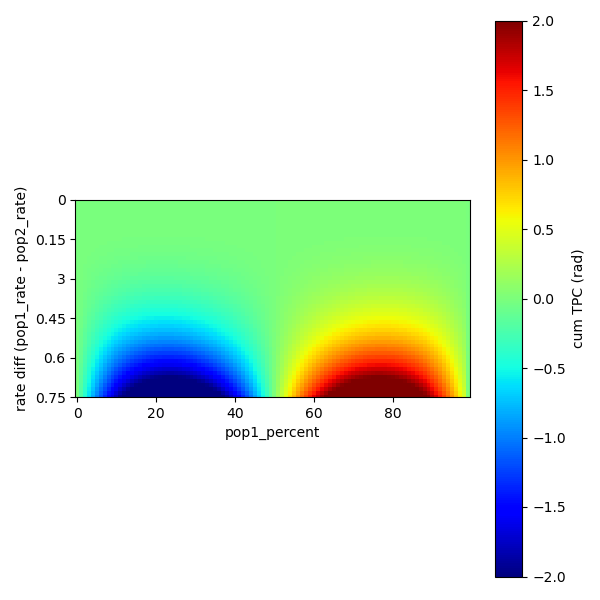

In [14]:
plt.figure(figsize=(6,6),tight_layout=True)
plt.imshow(TPC,cmap='jet',vmin=-2,vmax=2)
plt.ylabel('rate diff (pop1_rate - pop2_rate)')
plt.xlabel('pop1_percent')
plt.yticks(ticks=[0,10,20,30,40,50],labels=[0,0.15,3,0.45,0.6,0.75])
plt.colorbar(label='cum TPC (rad)')

plt.ylim([50,0])
plt.show()

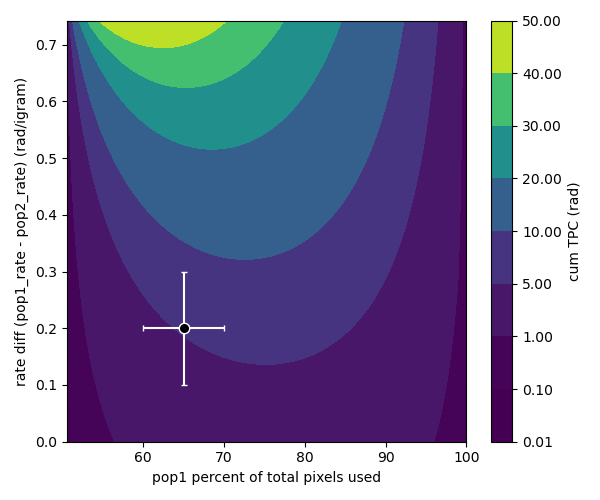

In [15]:
# X,Y = np.meshgrid(pop1_percents_to_loop,rate_diffs_to_loop)
X,Y = np.meshgrid(pop1_percents_to_loop[50::],rate_diffs_to_loop[0:50])

plt.figure(figsize=(6,5),tight_layout=True)
# plt.contourf(X,Y,TPC,inline=True)

#levels = [50,40,30,20,10,5,1,0.1,0.01,0.001]
levels = [0.01,0.1,1,5,10,20,30,40,50]
plt.contourf(X,Y,TPC[50::,50::],levels)
#plt.contourf(X,Y,logTPC[0:50,0:50],locator=ticker.LogLocator())

# add errorbar for the pop1-pop2 vels and the pop1 percentage 
# FIX VALUES ONCE ANALYSIS IS REDONE
plt.errorbar(65,0.2,yerr=0.1,xerr=5,fmt='.',ms=15,mfc='black',mec='white',color='white',capsize=2)

plt.ylabel('rate diff (pop1_rate - pop2_rate) (rad/igram)')
plt.xlabel('pop1 percent of total pixels used')
plt.colorbar(label='cum TPC (rad)')
plt.show()

# see what units y-axis is in, label it 
# choose it so that the rate we're seeing btw 2 populations is on the chart 
# doesn't need to go to the max 
# maybe show a dot or a line for my rate- try error bar with +-1sigma in x-direction and y-direction

Redo above plots but with inputting rate diffs in cm/yr instead of rad/igram. Use a different range.

In [16]:
print(1 / 365.25 * 12 * 4*np.pi / 5.5465763)
cm_yr_2_rad_igram = (12*4*np.pi)/(365.25*5.5465763)
print(0.7/cm_yr_2_rad_igram)

0.07443477738420431
9.404206267547


In [17]:
def calc_cumTPC_for_given_rate_diff_CMyr_and_pop1_percent(rate_diff_cm,pop1_perc):

    nd = 60
    n = 100

    # convert rate_diff that is input into this from cm/yr into rad/igram to work better in the loop 
    cm_yr_2_rad_igram = (12*4*np.pi)/(365.25*5.5465763)
    rate_diff = rate_diff_cm * cm_yr_2_rad_igram 

    # set the pop1 and pop2 rates
    pop2_rate = 0.0
    pop1_rate = rate_diff

    # initialize matrix for SLC phase values 
    SLCphs = np.ndarray((nd,n),dtype='float')
    
    # for each SLC, but in pop1_percent amount of pop1_rate, rest is pop2_rate
    for date in range(nd):
        # no noise 
        SLCphs[date,:]                   = pop2_rate
        SLCphs[date,0:int(pop1_perc)]    = pop1_rate

    # create SLCs as complex nums
    slcs    = np.exp(1j*SLCphs)
    slcs    = np.cumprod(slcs,0) # this makes sure that the rate is carried through 

    # create ints by complex conj of sequential SLCs 
    ints        = slcs[0:-1]*np.conj(slcs[1::]) # (nd-1,n) shape: nd-1 ints, n pixels 
    intsSkip1   = slcs[0:-2]*np.conj(slcs[2::])

    # initialize matrix to hold triplets 
    trips = np.ndarray((nd-2),dtype='float') 

    # loop through triplets
    for i in range(nd-2): 
        ab = ints[i]
        bc = ints[i+1]
        ac = intsSkip1[i]
        # "filter" them (just take average of the 100 pixels by summing then taking angle)
        abFilt = np.angle(np.sum(ab))
        bcFilt = np.angle(np.sum(bc))
        acFilt = np.angle(np.sum(ac))
        # calculate triplet
        trips[i] = abFilt + bcFilt - acFilt
    
    # sum the triplets over the whole interval, put into array
    TPC = np.sum(trips)
    
    return TPC

In [18]:
num_to_loop = 100

rate_diffs_to_loop_cm = np.linspace(0,10,num=num_to_loop,endpoint=True)
pop1_percents_to_loop = np.linspace(0,100,num=num_to_loop,endpoint=True)

TPCcm = np.ndarray((num_to_loop,num_to_loop),dtype='float')

for i in range(num_to_loop):        # rate diffs
    for j in range(num_to_loop):    # pop1 percents

        # call the function 
        TPCcm[i,j] = calc_cumTPC_for_given_rate_diff_CMyr_and_pop1_percent(rate_diffs_to_loop_cm[i],pop1_percents_to_loop[j])

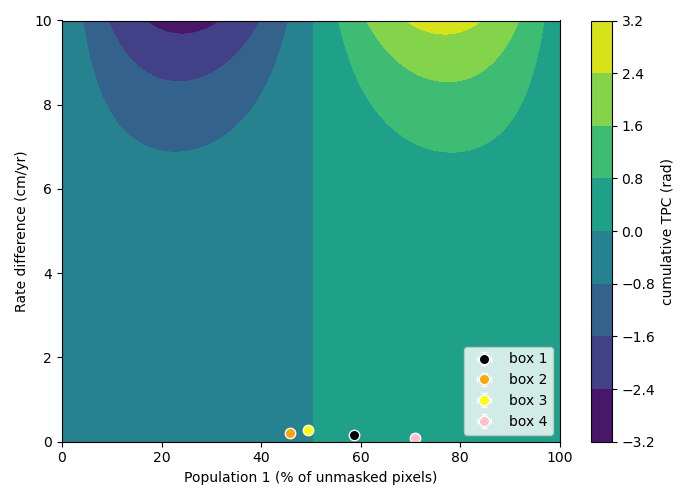

In [19]:
#X2,Y2 = np.meshgrid(pop1_percents_to_loop[50::],rate_diffs_to_loop_cm[0:50])
X2,Y2 = np.meshgrid(pop1_percents_to_loop,rate_diffs_to_loop_cm)

plt.figure(figsize=(7,5),tight_layout=True)
#levels = [50,40,30,20,10,5,1,0.1,0.01,0.001]
#levels = [0.01,0.1,1,5,10,20,30,40,50]

#plt.contourf(X2,Y2,TPCcm[50::,50::])


#plt.contourf(X,Y,logTPC[0:50,0:50],locator=ticker.LogLocator())

plt.contourf(X2,Y2,TPCcm)

# add errorbar for the pop1-pop2 vels and the pop1 percentage 
rate_diff_box1_avg = 0.1704432412494045
rate_diff_box1_std = 0.06965255424264197
pop1_percent_box1  = 58.651854153718666

rate_diff_box2_avg = 0.2037515033285223
rate_diff_box2_std = 0.04628134242084576
pop1_percent_box2  = 45.831400267445346

rate_diff_box3_avg = 0.2888827634636225
rate_diff_box3_std = 0.06301648377245216
pop1_percent_box3  = 49.50949457862429

rate_diff_box4_avg = 0.09981306344995491
rate_diff_box4_std = 0.07386961303518967
pop1_percent_box4  = 70.90900491865305

plt.errorbar(pop1_percent_box1,rate_diff_box1_avg,yerr=rate_diff_box1_std,xerr=0,fmt='.',ms=15,mfc='black',mec='white',color='white',capsize=2, label='box 1')
plt.errorbar(pop1_percent_box2,rate_diff_box2_avg,yerr=rate_diff_box2_std,xerr=0,fmt='.',ms=15,mfc='orange',mec='white',color='white',capsize=2, label='box 2')
plt.errorbar(pop1_percent_box3,rate_diff_box3_avg,yerr=rate_diff_box3_std,xerr=0,fmt='.',ms=15,mfc='yellow',mec='white',color='white',capsize=2, label='box 3')
plt.errorbar(pop1_percent_box4,rate_diff_box4_avg,yerr=rate_diff_box4_std,xerr=0,fmt='.',ms=15,mfc='pink',mec='white',color='white',capsize=2, label='box 4')
plt.legend(loc='lower right')

# plt.ylabel('rate diff (pop1_rate - pop2_rate) (cm/yr)')
plt.ylabel('Rate difference (cm/yr)')
#plt.xlabel('Populationop1 percent of unmasked pixels')
plt.xlabel('Population 1 (% of unmasked pixels)') # make it 0-1?
plt.colorbar(label='cumulative TPC (rad)')
plt.show()

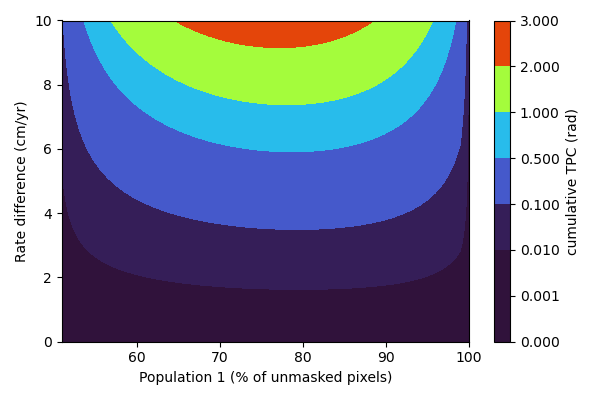

In [20]:
# plot just half of it. Making this for AGU poster 2023.
plt.figure(figsize=(6,4),tight_layout=True)
levels = [0,0.001,0.01,0.1,0.5,1,2,3]
plt.contourf(X2,Y2,TPCcm,levels,cmap='turbo')
plt.ylabel('Rate difference (cm/yr)')
plt.xlim([51,100])
plt.xlabel('Population 1 (% of unmasked pixels)') # make it 0-1?
plt.colorbar(label='cumulative TPC (rad)')
plt.show()

#plt.savefig('/data/ocp4/LagunaSalada/Data_and_Figs/17_pixel_populations/Rate_diffs_cum_TPC_contour_plot.png',transparent='True')